# Time Series prediction using DeepAR: BikeRental

There are 2 versions of models in this notebook:
1. Without categories in target - Note that here we send data for all 3 categories as 3 different time series
2. With categories in target - We specify the categories explicitly

Just specify with_categories flag to True. And at inference time, specify the category for which you want to predict

Training DeepAR with dynamic features (Not in this notebook):

- You cannot have NaN values in the features
- DeepAR can handle missing valeus in target, but not in dynamic features. You can use methods like forward fill, backward fill, group statistics (mean, median, mode), impute and/or interpolate (linear/quadratic)

# Step 1: Data pre-processing

In [77]:
import boto3
import sagemaker
import sagemaker.amazon.common as smac

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime

In [78]:
sess = sagemaker.Session()

In [ ]:
from sagemaker import get_execution_role
role = get_execution_role()
print(role)

Specify bucket with base dataset

In [80]:
s3_bucket_name = <Insert your bucket name here>

s3_basefolder = r'timeseries_data/Base_datasets/'

Read data

In [81]:
boto3.Session().resource('s3').Bucket(s3_bucket_name).download_file('timeseries_data/Base_datasets/train.csv', 'train.csv')

In [82]:
boto3.Session().resource('s3').Bucket(s3_bucket_name).download_file('timeseries_data/Base_datasets/test.csv', 'test.csv')

Specify True for with_categories for training with categories

In [83]:
target_values = ['count','registered','casual']

# controls if categories (in this case we are using it to indicate one of the above rentals) needs to be
# included in the training and test data
with_categories = True

In [84]:
# Set datetime column as index to work with data based on Date/Time
df = pd.read_csv('train.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0)

Understanding the data

In [85]:
# Minimum time and Maximum Time in Training CSV file
df.index.min(),df.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [86]:
# Minimum time and Maximum Time in test CSV file
df_test.index.min(),df_test.index.max()

(Timestamp('2011-01-20 00:00:00'), Timestamp('2012-12-31 23:00:00'))

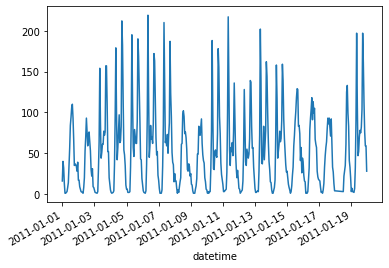

In [87]:
df['2011-01']['count'].plot()

Prediction length hyperparameter

In [88]:
hours_to_predict = []
print ('Check maximum hours we need to predict')
# Group by year, month and get prediction length
predict_window = df_test.groupby([df_test.index.year,df_test.index.month])
for i,x in predict_window:
    delta = x.index.max() - x.index.min() 
    hours = np.ceil(delta.total_seconds()/3600)
    hours_to_predict.append(hours)
    print ("{0}, Hours:{1}".format(i, hours))

print ("Maximum Prediction Length in Hours: ", np.max(hours_to_predict))

Check maximum hours we need to predict
(2011, 1), Hours:287.0
(2011, 2), Hours:215.0
(2011, 3), Hours:287.0
(2011, 4), Hours:263.0
(2011, 5), Hours:287.0
(2011, 6), Hours:263.0
(2011, 7), Hours:287.0
(2011, 8), Hours:287.0
(2011, 9), Hours:263.0
(2011, 10), Hours:287.0
(2011, 11), Hours:263.0
(2011, 12), Hours:287.0
(2012, 1), Hours:287.0
(2012, 2), Hours:239.0
(2012, 3), Hours:287.0
(2012, 4), Hours:263.0
(2012, 5), Hours:287.0
(2012, 6), Hours:263.0
(2012, 7), Hours:287.0
(2012, 8), Hours:287.0
(2012, 9), Hours:263.0
(2012, 10), Hours:287.0
(2012, 11), Hours:263.0
(2012, 12), Hours:287.0
Maximum Prediction Length in Hours:  287.0


In [89]:
freq='H' # Timeseries has hourly level data

# how far in the future predictions can be made
prediction_length = 288 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 288

In [90]:
dt_predict_max = pd.Timestamp("2012-12-31 23:00:00", freq=freq) #convert to timestamp data type

dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00", freq=freq)
dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00", freq=freq)

# use for model training
# Separate into train and validation (dev) set
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - datetime.timedelta(hours=12*24) )

# We can compare predicted values vs actual (i.e. last 12 days is withheld for validation and model hasn't seen that data)
dt_val_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 

Check for nulls in data

In [91]:
def is_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return not dt_range.equals(df[start:end].index)

def get_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return dt_range.difference(df[start:end].index)    

# List timeseries with ONLY NaNs
def timeseries_with_only_nans(df):
    l = []
    for col in df.columns:
        if pd.isna(df[col].min()):
            #print (col)
            l.append(col)
    return l

In [92]:
is_missing_steps(df, '2011-01-01 00:00:00', '2011-01-19 23:00:00','H')

True

In [93]:
get_missing_steps(df, '2011-01-01 00:00:00', '2011-01-19 23:00:00','H')

DatetimeIndex(['2011-01-02 05:00:00', '2011-01-03 02:00:00',
               '2011-01-03 03:00:00', '2011-01-04 03:00:00',
               '2011-01-05 03:00:00', '2011-01-06 03:00:00',
               '2011-01-07 03:00:00', '2011-01-11 03:00:00',
               '2011-01-11 04:00:00', '2011-01-12 03:00:00',
               '2011-01-12 04:00:00', '2011-01-14 04:00:00',
               '2011-01-18 00:00:00', '2011-01-18 01:00:00',
               '2011-01-18 02:00:00', '2011-01-18 03:00:00',
               '2011-01-18 04:00:00', '2011-01-18 05:00:00',
               '2011-01-18 06:00:00', '2011-01-18 07:00:00',
               '2011-01-18 08:00:00', '2011-01-18 09:00:00',
               '2011-01-18 10:00:00', '2011-01-18 11:00:00',
               '2011-01-19 03:00:00'],
              dtype='datetime64[ns]', freq=None)

In [94]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-02 00:00:00,1,0,0,2,18.86,22.725,88,19.9995,4,13,17
2011-01-02 01:00:00,1,0,0,2,18.04,21.970,94,16.9979,1,16,17
2011-01-02 02:00:00,1,0,0,2,17.22,21.210,100,19.0012,1,8,9
2011-01-02 03:00:00,1,0,0,2,18.86,22.725,94,12.9980,2,4,6
2011-01-02 04:00:00,1,0,0,2,18.86,22.725,94,12.9980,2,1,3
2011-01-02 06:00:00,1,0,0,3,17.22,21.210,77,19.9995,0,2,2
2011-01-02 07:00:00,1,0,0,2,16.40,20.455,76,12.9980,0,1,1
2011-01-02 08:00:00,1,0,0,3,16.40,20.455,71,15.0013,0,8,8
2011-01-02 09:00:00,1,0,0,2,15.58,19.695,76,15.0013,1,19,20


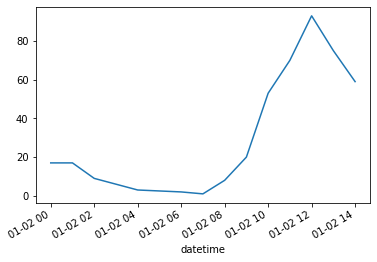

In [95]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']['count'].plot()

Use resample method to generate the missing timestamps

In [96]:
df = df.resample('1h').mean()

In [97]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-02 00:00:00,1.0,0.0,0.0,2.0,18.86,22.725,88.0,19.9995,4.0,13.0,17.0
2011-01-02 01:00:00,1.0,0.0,0.0,2.0,18.04,21.970,94.0,16.9979,1.0,16.0,17.0
2011-01-02 02:00:00,1.0,0.0,0.0,2.0,17.22,21.210,100.0,19.0012,1.0,8.0,9.0
2011-01-02 03:00:00,1.0,0.0,0.0,2.0,18.86,22.725,94.0,12.9980,2.0,4.0,6.0
2011-01-02 04:00:00,1.0,0.0,0.0,2.0,18.86,22.725,94.0,12.9980,2.0,1.0,3.0
2011-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-02 06:00:00,1.0,0.0,0.0,3.0,17.22,21.210,77.0,19.9995,0.0,2.0,2.0
2011-01-02 07:00:00,1.0,0.0,0.0,2.0,16.40,20.455,76.0,12.9980,0.0,1.0,1.0
2011-01-02 08:00:00,1.0,0.0,0.0,3.0,16.40,20.455,71.0,15.0013,0.0,8.0,8.0


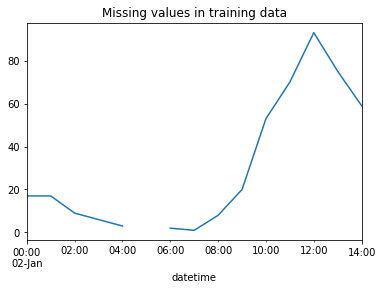

In [98]:
df['2011-01-02 00:00:00':'2011-01-02 14:00:00']['count'].plot(title='Missing values in training data')

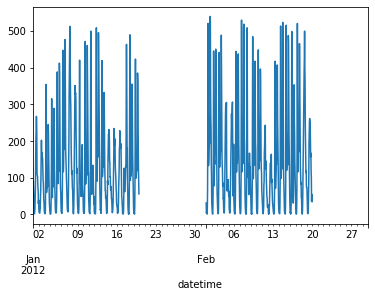

In [99]:
df['2012-01':'2012-02']['count'].plot()

In [100]:
#We need to predict this missing value

Separate into train and test

In [101]:
target_values

['count', 'registered', 'casual']

In [102]:
df[dt_val_range[0]:dt_val_range[1]]['count'].tail()

datetime
2012-12-19 19:00:00    336.0
2012-12-19 20:00:00    241.0
2012-12-19 21:00:00    168.0
2012-12-19 22:00:00    129.0
2012-12-19 23:00:00     88.0
Freq: H, Name: count, dtype: float64

In [103]:
dt_val_range

(Timestamp('2011-01-01 00:00:00', freq='H'),
 Timestamp('2012-12-19 23:00:00', freq='H'))

In [104]:
dt_train_range

(Timestamp('2011-01-01 00:00:00', freq='H'),
 Timestamp('2012-12-07 23:00:00', freq='H'))

In [105]:
time_series_val = []
time_series_training = []

for target in target_values:
    time_series_val.append(df[dt_val_range[0]:dt_val_range[1]][target])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][target])

In [106]:
time_series_val[0][:5],time_series_val[1][:5],time_series_val[2][:5]

(datetime
 2011-01-01 00:00:00    16.0
 2011-01-01 01:00:00    40.0
 2011-01-01 02:00:00    32.0
 2011-01-01 03:00:00    13.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: count, dtype: float64,
 datetime
 2011-01-01 00:00:00    13.0
 2011-01-01 01:00:00    32.0
 2011-01-01 02:00:00    27.0
 2011-01-01 03:00:00    10.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: registered, dtype: float64,
 datetime
 2011-01-01 00:00:00    3.0
 2011-01-01 01:00:00    8.0
 2011-01-01 02:00:00    5.0
 2011-01-01 03:00:00    3.0
 2011-01-01 04:00:00    0.0
 Freq: H, Name: casual, dtype: float64)

In [107]:
time_series_training[0][:5],time_series_training[1][:5],time_series_training[2][:5]

(datetime
 2011-01-01 00:00:00    16.0
 2011-01-01 01:00:00    40.0
 2011-01-01 02:00:00    32.0
 2011-01-01 03:00:00    13.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: count, dtype: float64,
 datetime
 2011-01-01 00:00:00    13.0
 2011-01-01 01:00:00    32.0
 2011-01-01 02:00:00    27.0
 2011-01-01 03:00:00    10.0
 2011-01-01 04:00:00     1.0
 Freq: H, Name: registered, dtype: float64,
 datetime
 2011-01-01 00:00:00    3.0
 2011-01-01 01:00:00    8.0
 2011-01-01 02:00:00    5.0
 2011-01-01 03:00:00    3.0
 2011-01-01 04:00:00    0.0
 Freq: H, Name: casual, dtype: float64)

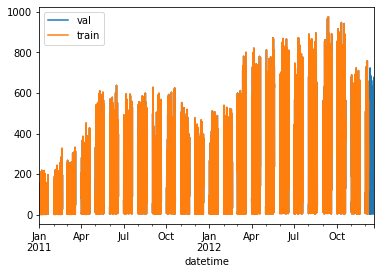

In [108]:
time_series_val[0].plot(label='val')
time_series_training[0].plot(label='train')#, ls=':')
plt.legend()
plt.show()

Convert to JSONLine format for Deep AR to understand

In [109]:
#Convert Nan values to Nan string for DeepAR
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

#Iterate through dynamic features column and converts it to list - throws error as Nan is not allowed in dyn features
def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

#Convert data to json
def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

#Convert json to jsonline
def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))   

In [110]:
list(time_series_training[0][:5])

[16.0, 40.0, 32.0, 13.0, 1.0]

In [111]:
series_to_obj(time_series_training[0][:5],[0] if with_categories else None)

{'start': '2011-01-01 00:00:00',
 'target': [16.0, 40.0, 32.0, 13.0, 1.0],
 'cat': [0]}

In [112]:
series_to_jsonline(time_series_training[0][:5],[0] if with_categories else None)

'{"start": "2011-01-01 00:00:00", "target": [16.0, 40.0, 32.0, 13.0, 1.0], "cat": [0]}'

In [113]:
encoding = "utf-8"
cat_idx = 0

train_file_name = "train.json"
val_file_name = "val.json"

if with_categories:
    train_file_name = "train_with_categories.json"
    val_file_name = "val_with_categories.json"

with open(train_file_name, 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts,[cat_idx] if with_categories else None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [114]:
cat_idx = 0
with open(val_file_name, 'wb') as fp:
    for ts in time_series_val:
        fp.write(series_to_jsonline(ts,[cat_idx] if with_categories else None).encode(encoding))
        fp.write('\n'.encode(encoding))
        cat_idx += 1

In [115]:
df.to_csv('all_data.csv',index=True,index_label='datetime')

In [116]:
for ts in time_series_training:
    print (len(ts),ts.name)

16968 count
16968 registered
16968 casual


In [117]:
for ts in time_series_val:
    print (len(ts),ts.name)

17256 count
17256 registered
17256 casual


# Step 2: Training

Specify True for with_categories for training with categories

In [118]:
# Name the base jobs for 2 versions of models: with and without categories

with_categories = True
if with_categories:
    base_job_name = 'DeepAR-biketrain-with-categories'
else:
    base_job_name = 'DeepAR-biketrain-no-categories'

Save files to channels

In [119]:
# Specify your bucket name
prefix = 'timeseries_data'

# This structure allows multiple training and test files for model development and testing
if with_categories:
    s3_data_path = "{}/{}/data_with_categories".format(s3_bucket_name, prefix)
else:
    s3_data_path = "{}/{}/data".format(s3_bucket_name, prefix)
    

s3_output_path = "{}/{}/output".format(s3_bucket_name, prefix)

In [ ]:
s3_data_path, s3_output_path

In [124]:
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [125]:
# Upload one or more training files and test files to S3
if with_categories:
    write_to_s3('train_with_categories.json',s3_bucket_name,'timeseries_data/data_with_categories/train/train_with_categories.json')
    write_to_s3('val_with_categories.json',s3_bucket_name,'timeseries_data/data_with_categories/val/val_with_categories.json')
else:
    write_to_s3('train.json',s3_bucket_name,'timeseries_data/data/train/train.json')
    write_to_s3('val.json',s3_bucket_name,'timeseries_data/data/val/val.json')

Download Image URI for DeepAR

In [126]:
# Use DeepAR Container
container = sagemaker.image_uris.retrieve("forecasting-deepar",sess.boto_region_name)

print (f'Using DeepAR Container {container}')

Using DeepAR Container 566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:1


In [127]:
container

'566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:1'

Configure Training Job

m5 is cheaper

In [136]:
# Resource Link: http://sagemaker.readthedocs.io/en/latest/estimators.html

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path="s3://" + s3_output_path,
    use_spot_instances=True,
    max_run = 300,
    max_wait = 600,
    sagemaker_session=sess,
    base_job_name=base_job_name)

In [137]:
freq, context_length, prediction_length

('H', 288, 288)

In [138]:
# Resource Link - https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html
hyperparameters = {
    "time_freq": freq,
    "epochs": "5",#can increase this to ~400
    "early_stopping_patience": "10",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "cardinality" : "auto" if with_categories else ''
}

In [139]:
hyperparameters

{'time_freq': 'H',
 'epochs': '5',
 'early_stopping_patience': '10',
 'mini_batch_size': '64',
 'learning_rate': '5E-4',
 'context_length': '288',
 'prediction_length': '288',
 'cardinality': 'auto'}

In [140]:
estimator.set_hyperparameters(**hyperparameters)

In [141]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/val/".format(s3_data_path)
}

In [2]:
data_channels

NameError: name 'data_channels' is not defined

In [143]:
# Takes half an hour
estimator.fit(inputs=data_channels)

2020-12-31 17:52:56 Starting - Starting the training job...
2020-12-31 17:52:57 Starting - Launching requested ML instancesProfilerReport-1609437176: InProgress
......
2020-12-31 17:54:08 Starting - Preparing the instances for training......
2020-12-31 17:55:21 Downloading - Downloading input data...
2020-12-31 17:55:49 Training - Training image download completed. Training in progress.Arguments: train
[12/31/2020 17:55:48 INFO 140654777812800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'st

In [144]:
job_name = estimator.latest_training_job.name

In [145]:
print ('job name: {0}'.format(job_name))

job name: DeepAR-biketrain-with-categories-2020-12-31-17-52-56-027


Create endpoint

In [146]:
endpoint_name = sess.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    image_uri=container,
    role=role)

---------------!

In [56]:
#endpoint_name = 'DeepARbikerental'

In [148]:
print ('endpoint name: {0}'.format(endpoint_name))

endpoint name: DeepAR-biketrain-with-categories-2020-12-31-17-52-56-027


### Step 3: Predictions

In [149]:
# Sagemaker notebooks
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.index[-1] + datetime.timedelta(hours=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat if dynamic_feat else None) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            #prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [150]:
# SDK 2 parameter name endpoint_name, content_type is specified as part of the serializer
predictor = DeepARPredictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess
)

predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = "application/json"

In [151]:
df = pd.read_csv('all_data.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0)
df = df.resample('1h').mean()

In [152]:
df.index[:5]

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')

In [153]:
target_values = ['count','registered','casual']
time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df[dt_val_range[0]:dt_val_range[1]][t])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][t])

In [154]:
# Provide 0 based index for categories
list_of_df = predictor.predict(time_series_training,
                               cat=[[0],[1],[2]] if with_categories else None)

In [155]:
for i in range(len(list_of_df)):
    print(len(list_of_df[i]))

288
288
288


Plot the predictions - 10th and 90th percentile give the confidence intervals

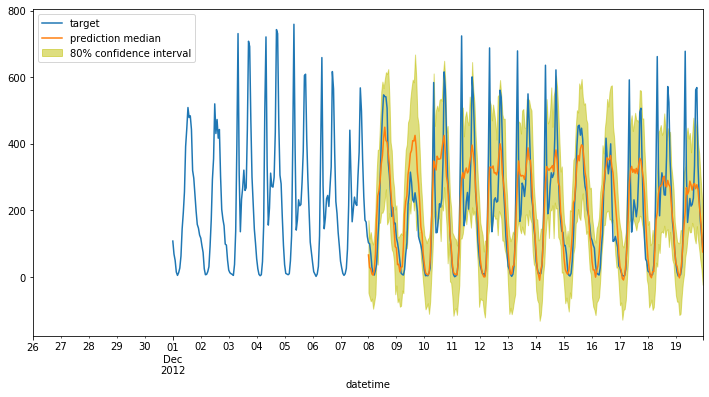

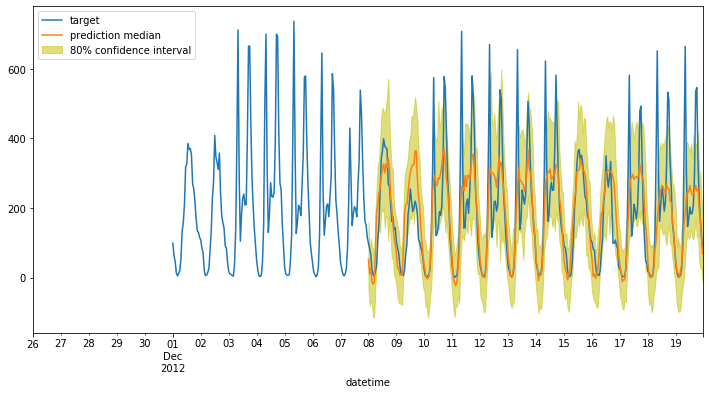

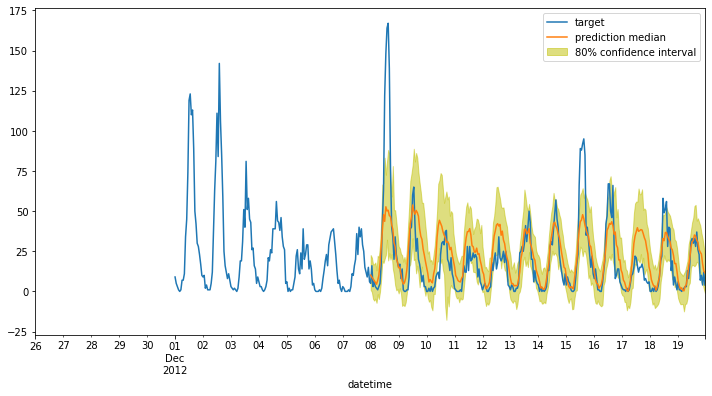

In [156]:
for k in range(len(list_of_df)):
    # print (-prediction_length-context_length) #120 = 72+48
    plt.figure(figsize=(12,6))
    
    time_series_test[k][-prediction_length-context_length:].plot(label='target')
    
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

In [157]:
predict_window = []
for i,x in df_test.groupby([df_test.index.year,df_test.index.month]):
    predict_window.append(x.index.min()-datetime.timedelta(hours=1))
predict_window

[Timestamp('2011-01-19 23:00:00'),
 Timestamp('2011-02-19 23:00:00'),
 Timestamp('2011-03-19 23:00:00'),
 Timestamp('2011-04-19 23:00:00'),
 Timestamp('2011-05-19 23:00:00'),
 Timestamp('2011-06-19 23:00:00'),
 Timestamp('2011-07-19 23:00:00'),
 Timestamp('2011-08-19 23:00:00'),
 Timestamp('2011-09-19 23:00:00'),
 Timestamp('2011-10-19 23:00:00'),
 Timestamp('2011-11-19 23:00:00'),
 Timestamp('2011-12-19 23:00:00'),
 Timestamp('2012-01-19 23:00:00'),
 Timestamp('2012-02-19 23:00:00'),
 Timestamp('2012-03-19 23:00:00'),
 Timestamp('2012-04-19 23:00:00'),
 Timestamp('2012-05-19 23:00:00'),
 Timestamp('2012-06-19 23:00:00'),
 Timestamp('2012-07-19 23:00:00'),
 Timestamp('2012-08-19 23:00:00'),
 Timestamp('2012-09-19 23:00:00'),
 Timestamp('2012-10-19 23:00:00'),
 Timestamp('2012-11-19 23:00:00'),
 Timestamp('2012-12-19 23:00:00')]

In [158]:
for t in target_values:
    df_test[t] = np.nan

In [159]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN


In [160]:
for window in predict_window:
    print(window)
    # If trained with categories, we need to send corresponding category for each training set
    # In this case
    for i in range(len(target_values)):
        list_of_df = predictor.predict([time_series_test[i][:window]],
                                       cat=[i] if with_categories else None)
        df_tmp = list_of_df[0]
        df_tmp.index.name = 'datetime'
        df_tmp.columns = ['0.1',target_values[i],'0.9']
        df_test.update(df_tmp[target_values[i]])

2011-01-19 23:00:00
2011-02-19 23:00:00
2011-03-19 23:00:00
2011-04-19 23:00:00
2011-05-19 23:00:00
2011-06-19 23:00:00
2011-07-19 23:00:00
2011-08-19 23:00:00
2011-09-19 23:00:00
2011-10-19 23:00:00
2011-11-19 23:00:00
2011-12-19 23:00:00
2012-01-19 23:00:00
2012-02-19 23:00:00
2012-03-19 23:00:00
2012-04-19 23:00:00
2012-05-19 23:00:00
2012-06-19 23:00:00
2012-07-19 23:00:00
2012-08-19 23:00:00
2012-09-19 23:00:00
2012-10-19 23:00:00
2012-11-19 23:00:00
2012-12-19 23:00:00


In [71]:
# Cap negative values at 0
def adjust_count(x):
    if x < 0:
        return 0
    else:
        return x

In [73]:
df_test['count'] = df_test['count'].map(adjust_count)

In [74]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,registered,casual
datetime,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,36.703701,40.319805,4.247188
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,28.587982,28.369034,3.674265
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,36.604736,14.396706,3.663383
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,24.407047,24.114780,3.071987
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,37.936180,24.833061,2.930796


In [76]:
# Store the results
if with_categories:
    df_test[['count']].to_csv('prediction-with-categories.csv',index=True,index_label='datetime')
else:
    df_test[['count']].to_csv('prediction.csv',index=True,index_label='datetime')

In [161]:
predictor.delete_endpoint()